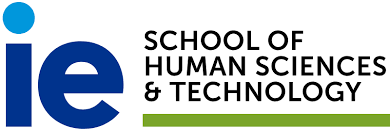


# Spark - Final Assignment
##  Music Recommender for Audioscrobbler.com

### Group C:
- Leandro Handal
- Philippe El Hage
- Daan Pelt
- Julius Oldorf
- Mohammed El Charif
- Meredith Hayward
- Yub Hahm



### Music Listening Dataset
### Audioscrobbler.com
#### 6 May 2005

This data set contains profiles for around 150,000 real people
The dataset lists the artists each person listens to, and a counter
indicating how many times each user played each artist

The dataset is continually growing; at the time of writing (6 May 2005) 
Audioscrobbler is receiving around 2 million song submissions per day

We may produce additional/extended data dumps if anyone is interested 
in experimenting with the data. 

Please let us know if you do anything useful with this data, we're always
up for new ways to visualize it or analyse/cluster it etc :)


#### License

This data is made available under the following Creative Commons license:
http://creativecommons.org/licenses/by-nc-sa/1.0/


#### Files

user_artist_data.txt
   - 3 columns: userid artistid playcount

artist_data.txt
   - 2 columns: artistid artist_name

artist_alias.txt
   - 2 columns: badid, goodid
    known incorrectly spelt artists and the correct artist id. 
    you can correct errors in user_artist_data as you read it in using this file
    (we're not yet finished merging this data)
    
    
Contact Info
<rj@audioscrobbler.com>
irc://irc.audioscrobbler.com/audioscrobbler

## Start a SparkSession
This will start a local Spark session.

In [151]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions","5")

## Load Datasets
Load and inspect Datasets. We load the three available datasets `user_artist_data.txt`, `artist_data.txt` and `artist_alias.txt`

In [74]:
from pyspark.sql.types import StructField, StringType, IntegerType, StructType, ByteType

In [75]:
data = spark.read.csv('./profiledata_06-May-2005/user_artist_data.txt', sep=' ', inferSchema = True)

In [76]:
customSchemaArtists = StructType([ \
    StructField("artistid", IntegerType(), True), \
    StructField("name", StringType(), True)])

artists = spark.read.csv('./profiledata_06-May-2005/artist_data.txt', sep='\t', schema = customSchemaArtists)


In [77]:
aliases = spark.read.csv('./profiledata_06-May-2005/artist_alias.txt', sep='\t', inferSchema=True)
aliases = aliases.withColumnRenamed("_c0", "mispelledid").withColumnRenamed("_c1", "artistid")

In [78]:
data = data.withColumnRenamed("_c0", "userid").withColumnRenamed("_c1", "artistid").withColumnRenamed("_c2", "plays")

In [79]:
data.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            userid|          artistid|            plays|
+-------+------------------+------------------+-----------------+
|  count|          24296858|          24296858|         24296858|
|   mean|1947573.2653533637|1718704.0937568964|15.29576248089362|
| stddev| 496000.5551819092| 2539389.092428337|153.9153244697962|
|    min|                90|                 1|                1|
|    max|           2443548|          10794401|           439771|
+-------+------------------+------------------+-----------------+



## Removing Outliers

This is doing two things: 
1. Clipping the lower tail for our ALS algorithm to work better, since in order to have recommendations in collaborative filtering, we need to know our users preferences. Therefore any user with less than 5 plays of an artist is no good to predict.


2. Removing the right tail outliers that skew our data and may bias our analysis.

In [80]:
subset = data.filter((data['plays'] >= 5) & (data['plays'] <= 1000))

In [81]:
subset.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            userid|          artistid|            plays|
+-------+------------------+------------------+-----------------+
|  count|           9307579|           9307579|          9307579|
|   mean| 1939013.336777265|1319484.9944439903|33.86969006655759|
| stddev|490854.13913763873|2015181.4148142822|66.60665066398167|
|    min|                90|                 1|                5|
|    max|           2443507|          10794325|             1000|
+-------+------------------+------------------+-----------------+



In [82]:
subset.show()

+-------+--------+-----+
| userid|artistid|plays|
+-------+--------+-----+
|1000002|       1|   55|
|1000002| 1000006|   33|
|1000002| 1000007|    8|
|1000002| 1000009|  144|
|1000002| 1000010|  314|
|1000002| 1000013|    8|
|1000002| 1000014|   42|
|1000002| 1000017|   69|
|1000002| 1000024|  329|
|1000002| 1000028|   17|
|1000002| 1000031|   47|
|1000002| 1000033|   15|
|1000002| 1000055|   25|
|1000002| 1000062|   71|
|1000002| 1000088|  157|
|1000002| 1000099|   57|
|1000002| 1000113|   30|
|1000002| 1000123|   27|
|1000002| 1000127|   53|
|1000002| 1000139|   56|
+-------+--------+-----+
only showing top 20 rows



## Check Skewness

We now check the skewness of our target variable to see if we will have to transform it later on.

In [83]:
subset_pd = subset.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

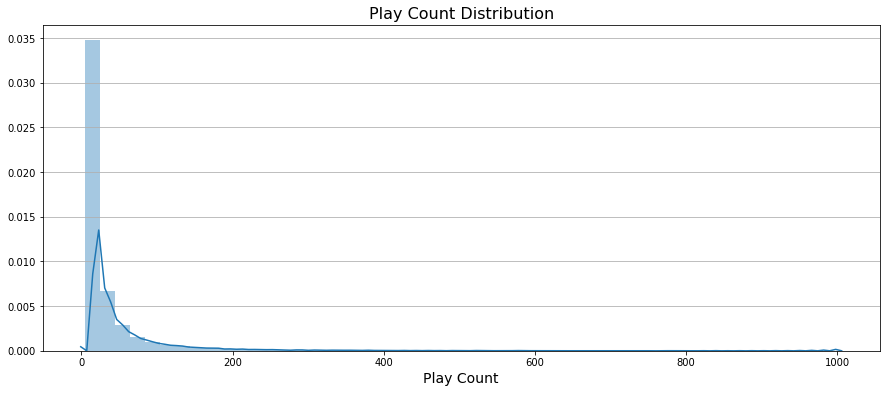

In [84]:
plt.subplots(figsize=(15, 6))
sns.distplot(subset_pd.plays)
plt.grid(which="major", axis="y")
plt.xlabel("Play Count", size=14)
plt.title("Play Count Distribution", size=16);

In [85]:
from pyspark.sql.functions import isnan, when, count, col, log1p, expm1, instr

## Null Values

Checking if there is any null values in any of the columns of our dataset.

In [86]:
subset.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+------+--------+-----+
|userid|artistid|plays|
+------+--------+-----+
|     0|       0|    0|
+------+--------+-----+



In [87]:
subset.printSchema

<bound method DataFrame.printSchema of DataFrame[userid: int, artistid: int, plays: int]>

## Combination of Datasets

In [88]:
artists.show()

+--------+--------------------+
|artistid|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
|10186265|Jota Quest e Ivet...|
| 6828986|       Toto_XX (1977|
|10236364|         U.S Bombs -|
| 1135000|artist formaly kn...|
|10299728|Kassierer - Musik...|
|10299744|         Rahzel, RZA|
| 6864258|      Jon Richardson|
| 6878791|Young Fresh Fello...|
|10299751|          Ki-ya-Kiss|
| 6909716|Underminded - The...|
|10435121|             Kox-Box|
| 6918061|  alexisonfire [wo!]|
| 1135001|         dj salinger|
| 6940391|The B52's - Chann...|
|10475396|             44 Hoes|
+--------+--------------------+
only showing top 20 rows



In [89]:
artists.describe().show()

+-------+-----------------+---------------+
|summary|         artistid|           name|
+-------+-----------------+---------------+
|  count|          1848281|        1848282|
|   mean|7028265.171776369|       Infinity|
| stddev|3753055.545402783|            NaN|
|    min|                1|              |
|    max|         10794305|￿￿￿￿￿￿￿￿￿￿￿￿くȁ|
+-------+-----------------+---------------+



### Misspelled IDs

As we can see here, most artists have mispelled IDs, for example we take the band Aerosmith. We can see it repeats itself various times having different IDs, which may bias our predictions.

In [90]:
artists.createOrReplaceTempView("artists")

sqlDF = spark.sql("SELECT * FROM artists where name like 'Aerosmith%'")

In [91]:
sqlDF.show()

+--------+--------------------+
|artistid|                name|
+--------+--------------------+
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 2027746|Aerosmith by Musi...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10479781|      Aerosmith Hits|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
|10594066|Aerosmith - JPP - 07|
|10594406|Aerosmith - JPP - 04|
|10482681|Aerosmith - O, Ye...|
|10033746| Aerosmith/Aerosmith|
| 1267101|Aerosmith With Bo...|
| 1269416|  Aerosmith & RunDmc|
|10441202|Aerosmith With Le...|
|10239445|   Aerosmith - [EMG]|
| 1157432|Aerosmith (Pandor...|
| 9935381|Aerosmith - Nine ...|
+--------+--------------------+
only showing top 20 rows



In [92]:
artists[artists.artistid==1000010].show()
artists[artists.artistid==2082323].show()

+--------+---------+
|artistid|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistid|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+--------+------------+



In [93]:
aliases[aliases.mispelledid==1000010].show()
aliases[aliases.mispelledid==2082323].show()

+-----------+--------+
|mispelledid|artistid|
+-----------+--------+
+-----------+--------+

+-----------+--------+
|mispelledid|artistid|
+-----------+--------+
|    2082323| 1000010|
+-----------+--------+



We here create a function, to check if an ID is standard or it has a misspelled double.

In [94]:
def is_standard(id1):
    """Return True is the ID is not in the mispelledID column of artistAliasDF"""
    if aliases[aliases.mispelledid==id1].collect()==[]:
        return True
    else:
        return False

Check if the function runs correctly.

In [95]:
name1 = "Green Day - Oasis - Eminem - Aerosmith"
id1 = artists[artists.name==name1].select('artistid').show(1)
is_standard(id1)

+--------+
|artistid|
+--------+
|10586963|
+--------+



True

### Join Datasets

Now we will join the datasets to be able to see exactly which `artistID` is which. We will use the previous function to map and replace misspelled IDs with the correct ones. This will help with our predictions since the same artist coul have had different IDs and therefore being counted less for the rating.

In [96]:
subset[subset.artistid==id1].collect()
strangeuserid=subset[subset.artistid==id1].userid
strangeUserActivity = subset[subset.userid==strangeuserid]
artists = strangeUserActivity.join(artists, on="artistid")

In [97]:
artists[artists.artistid==1000010].show()
artists[artists.artistid==2082323].show()

+--------+-------+-----+---------+
|artistid| userid|plays|     name|
+--------+-------+-----+---------+
| 1000010|1000002|  314|Aerosmith|
| 1000010|1000019|   11|Aerosmith|
| 1000010|1000022|   78|Aerosmith|
| 1000010|1000025|   50|Aerosmith|
| 1000010|1000028|   29|Aerosmith|
| 1000010|1000060|    6|Aerosmith|
| 1000010|1000071|    9|Aerosmith|
| 1000010|1000092|    8|Aerosmith|
| 1000010|1000098|    7|Aerosmith|
| 1000010|1000180|   25|Aerosmith|
| 1000010|1000239|   13|Aerosmith|
| 1000010|1000241|   17|Aerosmith|
| 1000010|1000246|   10|Aerosmith|
| 1000010|1000288|   41|Aerosmith|
| 1000010|1000326|   10|Aerosmith|
| 1000010|1000346|   29|Aerosmith|
| 1000010|1000356|   22|Aerosmith|
| 1000010|1000376|    5|Aerosmith|
| 1000010|1000471|    9|Aerosmith|
| 1000010|1000509|   17|Aerosmith|
+--------+-------+-----+---------+
only showing top 20 rows

+--------+------+-----+----+
|artistid|userid|plays|name|
+--------+------+-----+----+
+--------+------+-----+----+



In [98]:
subset = artists
subset.describe().show()

+-------+------------------+------------------+-----------------+--------------+
|summary|          artistid|            userid|            plays|          name|
+-------+------------------+------------------+-----------------+--------------+
|  count|           9306376|           9306376|          9306376|       9306168|
|   mean|1319277.8503197164|1939115.8133319565|33.87218537054596|      Infinity|
| stddev| 2015061.840234866| 490788.6269733193|66.61000116270132|           NaN|
|    min|                 1|                90|                5|            Z|
|    max|          10794235|           2443507|             1000|￾氀挀 渀䌀愀渀|
+-------+------------------+------------------+-----------------+--------------+



## Scaling Target Variable

We tried scaling the target variable, but the results were way worse.

In [28]:
#from pyspark.ml.feature import StandardScaler

In [29]:
#scaler = StandardScaler(inputCol='plays', outputCol='scaled_plays')

In [30]:
#subset = subset.withColumn('norm_plays', (subset["plays"]-5)/(1000-5))

In [31]:
#subset.describe().show()

This didn't work :(

## Log-transform Target Variable

As we saw above, our target variable was skewed to the right, therefore we log-transform it to try to normalize its distribution.

In [48]:
subset = subset.withColumn("log_plays",log1p("plays"))

In [33]:
subset_pd = subset.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

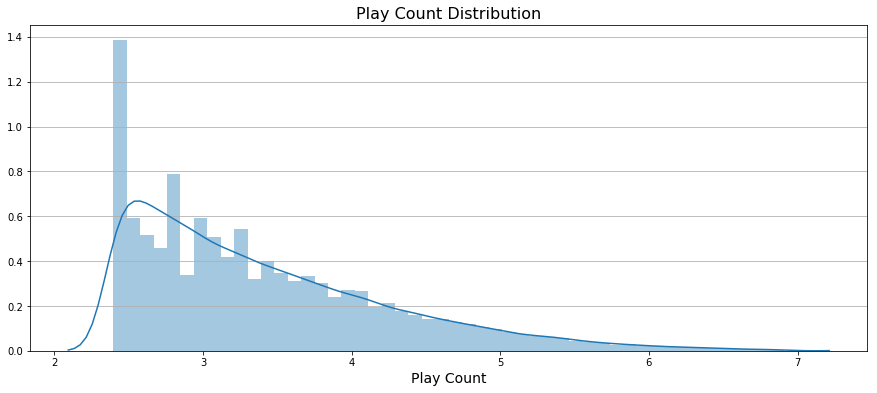

In [34]:
plt.subplots(figsize=(15, 6))
sns.distplot(subset_pd.log_plays)
plt.grid(which="major", axis="y")
plt.xlabel("Play Count", size=14)
plt.title("Play Count Distribution", size=16);

## Train / Test Split

In [49]:
train, test = subset.randomSplit([0.8, 0.2], seed=42)

## Base ALS Model
Base ALS model with no optimization.

In [36]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [37]:
als = ALS(maxIter=5, regParam=0.01, userCol='userid', itemCol='artistid', ratingCol='log_plays')

In [50]:
model = als.fit(train)

In [138]:
predictions = model.transform(test)

In [139]:
predictions = predictions.dropna(subset=('prediction'))

In [140]:
predictions.show()

+-------+--------+-----+------------------+----------+
| userid|artistid|plays|         log_plays|prediction|
+-------+--------+-----+------------------+----------+
|1026623|      22|   90|  4.51085950651685| 3.0804894|
|1034321|      22|   47|3.8712010109078907|   4.90341|
|1065798|      22|   10|2.3978952727983707|  2.551156|
|2118415|      22|   11|2.4849066497880004| 3.5689409|
|2026886|      23|   19| 2.995732273553991|  2.051199|
|2176976|      23|   17|2.8903717578961645| 1.8093895|
|2213999|      23|   18|2.9444389791664403| 2.9078264|
|2327206|      23|    6|1.9459101490553132| 1.7415116|
|2060053|      23|   32|3.4965075614664802| 1.6686716|
|2065317|      23|   48|3.8918202981106265| 2.3710458|
|1005157|      24|   12|2.5649493574615367| 2.6763113|
|1051303|      24|    5| 1.791759469228055|  2.112789|
|1071243|      24|   32|3.4965075614664802|   3.41593|
|2047761|      24|   13| 2.639057329615259| 2.3802383|
|2070889|      24|   69| 4.248495242049359| 3.1962953|
|2091925| 

In [54]:
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='log_plays', predictionCol='prediction')
rmse = evaluator_rmse.evaluate(predictions.na.drop()) 

In [55]:
evaluator_r2 = RegressionEvaluator(metricName='r2', labelCol='log_plays', predictionCol='prediction')
r2 = evaluator_r2.evaluate(predictions.na.drop())


In [ ]:
# RMSE
# 0.9648000586786721

# R Squared
# 0.022719838880952192

In [56]:
print('RMSE (Log)')
print(rmse)
print()
print('RMSE')
print(np.expm1(rmse))
print()
print('R Squared')
print(r2)
print()

RMSE (Log)
0.9648764545544265

RMSE
1.6244633959448886

R Squared
0.02256506457511187



## Hyperparameter Optimization

The following parameters should get consideration before training models:

- `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user
    feature and product-feature matrices. In non-trivial cases, this is also their rank.

- `iterations = 20`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

- `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

- `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization.

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 

In [57]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [58]:
paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10, 20]).addGrid(als.maxIter, [20]).addGrid(als.regParam, [0.001, 0.005, 0.01, 0.1]).build()

In [59]:
als_cv = ALS(userCol='userid', itemCol='artistid', ratingCol='log_plays')

crossval = CrossValidator(estimator=als_cv, estimatorParamMaps=paramGrid, evaluator=evaluator_rmse, numFolds=3)

In [60]:
cvModel = crossval.fit(train)

In [61]:
predictions_cv = cvModel.transform(test)

In [62]:
rmse_cv = evaluator_rmse.evaluate(predictions_cv.na.drop())
r2_cv = evaluator_r2.evaluate(predictions_cv.na.drop())

In [109]:
predictions_cv.show()

+-------+--------+-----+------------------+----------+
| userid|artistid|plays|         log_plays|prediction|
+-------+--------+-----+------------------+----------+
|1026623|      22|   90|  4.51085950651685| 2.5799642|
|1034321|      22|   47|3.8712010109078907| 3.6716945|
|1065798|      22|   10|2.3978952727983707| 2.5890229|
|2118415|      22|   11|2.4849066497880004|  2.756516|
|2026886|      23|   19| 2.995732273553991|  2.670317|
|2176976|      23|   17|2.8903717578961645| 2.2951388|
|2213999|      23|   18|2.9444389791664403| 2.2533238|
|2327206|      23|    6|1.9459101490553132| 2.1248004|
|2060053|      23|   32|3.4965075614664802| 2.4041138|
|2065317|      23|   48|3.8918202981106265| 2.8035102|
|1005157|      24|   12|2.5649493574615367| 2.9949515|
|1051303|      24|    5| 1.791759469228055| 2.5349863|
|1071243|      24|   32|3.4965075614664802| 3.0196362|
|2047761|      24|   13| 2.639057329615259| 2.5116944|
|2070889|      24|   69| 4.248495242049359| 2.5620253|
|2091925| 

In [63]:
print('RMSE (Log)')
print(rmse_cv)
print()
print('RMSE')
print(np.expm1(rmse_cv))
print()
print('R Squared')
print(r2_cv)

RMSE (Log)
0.8645573534915653

RMSE
1.3739550304658306

R Squared
0.21524867383443358


### Get Best Hyperparameters

In [ ]:
#{maxIter: 20, regParam: 0.001, rank: 1}

In [65]:
cvModel.explainParams()

"estimator: estimator to be cross-validated (current: ALS_cadd011f218e)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='ALS_56f8bd4d568e', name='rank', doc='rank of the factorization'): 1, Param(parent='ALS_56f8bd4d568e', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_56f8bd4d568e', name='regParam', doc='regularization parameter (>= 0).'): 0.001}, {Param(parent='ALS_56f8bd4d568e', name='rank', doc='rank of the factorization'): 1, Param(parent='ALS_56f8bd4d568e', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_56f8bd4d568e', name='regParam', doc='regularization parameter (>= 0).'): 0.005}, {Param(parent='ALS_56f8bd4d568e', name='rank', doc='rank of the factorization'): 1, Param(parent='ALS_56f8bd4d568e', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_56f8bd4d568e', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='ALS_56f8bd4d568e', name='rank'

---

## Findings and Recommendations

In this section we will show the results of the analysis and some recommendations for useres.

### Show Top 10 Recommendations For Each User and Artist

In [66]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each artist
artistRecs = model.recommendForAllItems(10)


In [ ]:
#userRecs.head().show()

In [ ]:
#artistRecs.show()

### Top 10 Artists Per Play Counts

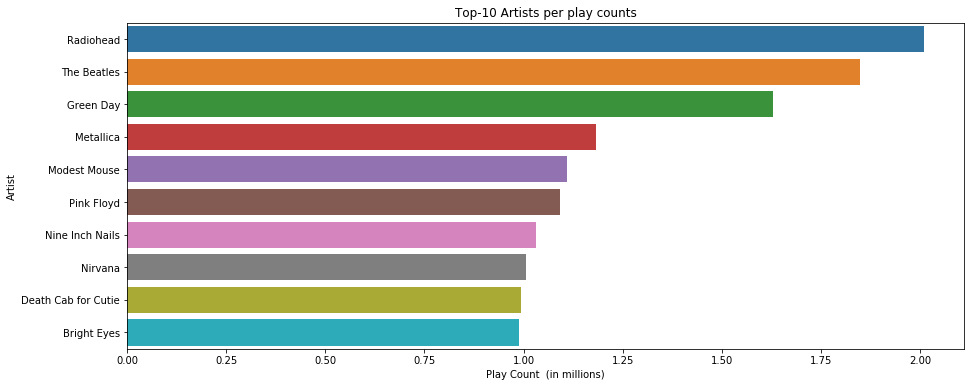

In [99]:
top10ArtistsPC = subset.groupBy("name").sum("plays").orderBy('sum(plays)', ascending=0).take(10)
top10ArtistsPC = pd.DataFrame(data=top10ArtistsPC)

plt.subplots(figsize=(15, 6))
sns.barplot(x=top10ArtistsPC[1]/1000000, y=top10ArtistsPC[0])
plt.xlabel('Play Count  (in millions)')
plt.ylabel('Artist')
plt.title('Top-10 Artists per play counts');

### Top-10 Artists Per Audience Size

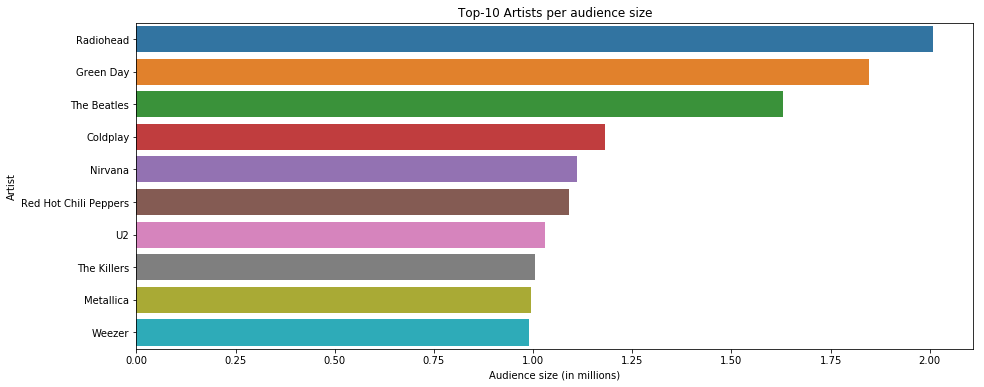

In [100]:
top10ArtistsUC = (subset.dropDuplicates(['userid', 'artistid']).groupBy("name").count().orderBy("count", ascending=0).take(10))
top10ArtistsUC = pd.DataFrame(top10ArtistsUC)

plt.subplots(figsize=(15, 6))
sns.barplot(x=top10ArtistsPC[1]/1000000, y=top10ArtistsUC[0])
plt.xlabel('Audience size (in millions)')
plt.ylabel('Artist')
plt.title('Top-10 Artists per audience size');

### Top 10 Users (Play Count)

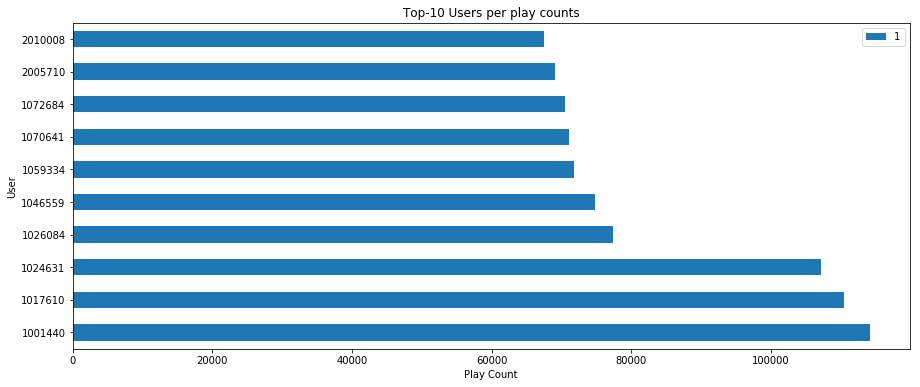

In [101]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount = subset.groupBy("userid").sum("plays").orderBy('sum(plays)', ascending=0).take(10)
top10UsersByPlayCount = pd.DataFrame(top10UsersByPlayCount)
top10UsersByPlayCount[0] = top10UsersByPlayCount[0].astype(str)
topusers = top10UsersByPlayCount[0].astype(str)
top10UsersByPlayCount[0] = pd.DataFrame(topusers)
top10UsersByPlayCount.set_index(topusers.sort_values(ascending=True), inplace=True)
top10UsersByPlayCount.drop(columns=0)

top10UsersByPlayCount.plot(kind='barh', figsize=(15,6))
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users per play counts');

### Top 10 Users (Curiosity)

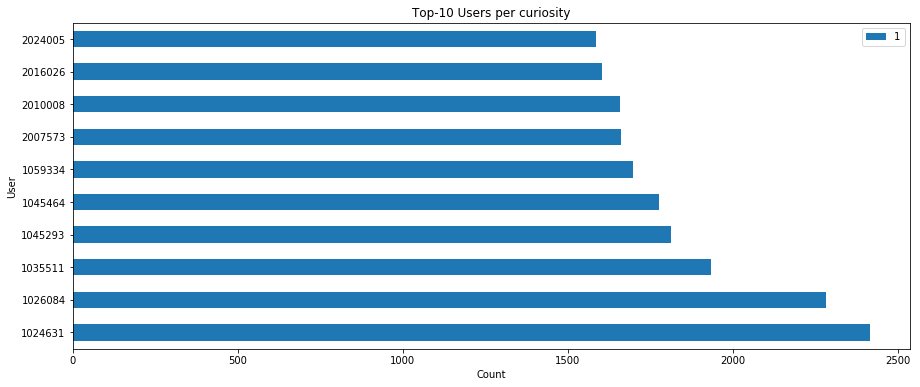

In [102]:
# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (subset.dropDuplicates(['userid', 'name'])
                          .groupBy(str("userid"))
                          .count()
                          .orderBy("count", ascending=0)
                          .take(10))

top10UsersByCuriosity = pd.DataFrame(top10UsersByCuriosity)

top10UsersByCuriosity[0] = top10UsersByCuriosity[0].astype(str)
topusers = top10UsersByCuriosity[0].astype(str)
top10UsersByCuriosity[0] = pd.DataFrame(topusers)
top10UsersByCuriosity.set_index(topusers.sort_values(ascending=True), inplace=True)
top10UsersByCuriosity.drop(columns=0)

top10UsersByCuriosity.plot(kind='barh', figsize=(15,6))
plt.xlabel('Count')
plt.ylabel('User')
plt.title('Top-10 Users per curiosity');

### Show Predictions For a Single User

First we will merge the final datasets to have the artist name instead of the ID and dropping the duplicates, then we proceed to scale predictions to make them easier to interpret. 

In [144]:
predictions = predictions.join(subset.drop(subset['userid']).drop(subset['plays']), on="artistid").dropDuplicates()

In [146]:
predictions = predictions.withColumn('scaled_prediction', (predictions["prediction"]+9.208462)/(15.73186+9.208462))

We now create a function to show the top predictions for any user.

In [164]:
def user_predictions(user):
    single_user = predictions.filter(test["userid"] == user).select(
        ["userid", "name", "scaled_prediction"]
    )
    single_user.withColumn("artist", (single_user["name"])).drop(
        single_user["name"]
    ).orderBy("scaled_prediction", ascending=False).show(truncate=False)
options = [2060053, 1024631, 1026623, 1000002, 1071243, 1026623, 1071243, 2091925, 2287497, 2327206, 1005157, 2060053, 1024631, 1026623, 1000002, 1071243, 1026623, 1071243, 2091925, 2287497, 2327206, 1005157]



Here we make use of widgets to create an interactive drop-down menu to query predictions based on the chosen user.

In [173]:
interact(user_predictions, user=options);

interactive(children=(Dropdown(description='user', options=(2060053, 1024631, 1026623, 1000002, 1071243, 10266…

## Possible Improvements

Here we tried only a few combination of parameters by lack of time. If this application had a real commercial purpose, we would have used an algorithm like gradient descent on a function like accuracy = f(rank, lambda, alpha). Because it could have taken a lot of time to find the optimal parameters, but we wouldn't have needed to do the gradient descent again for each training. Furthermore, we could change the iteration parameter but it would impact the training performance. Again it depends on the use of our recommendation algorithm. If we consider that a single model could get meaningful recommendations for several weeks, we could allow ourselves to increase the number of iterations (therefore increasing the creation time of the model).

## Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.